# COVID-19 Analysis: Pre-existing Health Conditions vs COVID-19 Outcomes

## Research Question
Do chronic diseases predict worse COVID-19 outcomes across populations?

## Information Theory Context
This analysis explores a **non-obvious relationship** where the outcome is not immediately predictable. 
According to information theory, information content is inversely proportional to the probability of an outcome: 
**I ∝ 1/P(outcome)**. Surprising results contain more information than expected ones.

**Independent Variable**: `diabetes_prevalence`  
**Dependent Variable**: `total_deaths_per_million`  
**Analysis Type**: Cross Sectional

---


## Prevailing Narrative

Clinical evidence consistently showed that **pre-existing conditions** (diabetes, cardiovascular disease, obesity) significantly increased individual risk of severe COVID-19 outcomes. Public health authorities identified populations with high chronic disease burden as particularly vulnerable, suggesting that countries with higher comorbidity prevalence would face worse pandemic outcomes.

### Working Hypothesis
Based on this prevailing narrative, we would expect: **moderate positive** correlation between 
`diabetes_prevalence` and `total_deaths_per_million`.  
In plain language: Higher chronic disease prevalence should correlate with higher mortality

### Sources
- CDC list of underlying medical conditions\n- Meta-analyses of comorbidities and COVID-19 severity

---


In [1]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from pathlib import Path
import sys

# Add project root to path and import config
project_root = Path('.').resolve().parent
sys.path.insert(0, str(project_root))
import config

# Set visualization defaults
sns.set_theme(style='whitegrid', palette='muted')
plt.rcParams['figure.figsize'] = (14, 8)
plt.rcParams['font.size'] = 11

# Data path using config
data_path = project_root / config.data_dir / 'owid-covid-data.csv'
print(f'Data source: {data_path}')

Data source: /Users/john/Python/PublicHealthPortfolio/my-projects/covid19-tracker/Data/owid-covid-data.csv


## 1. Data Loading

Loading relevant columns from OWID COVID-19 dataset:
- `date`, `location`, `diabetes_prevalence`, `cardiovasc_death_rate`, `total_deaths_per_million`, `total_cases_per_million`

In [2]:
# Load data with relevant columns
columns_needed = ['date', 'location', 'diabetes_prevalence', 'cardiovasc_death_rate', 'total_deaths_per_million', 'total_cases_per_million']

try:
    df = pd.read_csv(
        data_path,
        usecols=columns_needed,
        parse_dates=['date']
    )
    
    print(f'✓ Loaded {len(df):,} rows')
    print(f'\nColumns: {list(df.columns)}')
    print(f'\nDate range: {df["date"].min()} to {df["date"].max()}')
    print(f'\nCountries: {df["location"].nunique()}')
    
    # Display sample
    display(df.head(10))
    
except FileNotFoundError:
    print(f'❌ Data file not found: {data_path}')
    print('Download from: https://github.com/owid/covid-19-data')
except Exception as e:
    print(f'❌ Error loading data: {e}')

✓ Loaded 429,300 rows

Columns: ['location', 'date', 'total_cases_per_million', 'total_deaths_per_million', 'cardiovasc_death_rate', 'diabetes_prevalence']

Date range: 2020-01-01 00:00:00 to 2024-08-04 00:00:00

Countries: 255


,location,date,total_cases_per_million,total_deaths_per_million,cardiovasc_death_rate,diabetes_prevalence
0,Afghanistan,2020-01-05,0.0,0.0,597.03,9.59
1,Afghanistan,2020-01-06,0.0,0.0,597.03,9.59
2,Afghanistan,2020-01-07,0.0,0.0,597.03,9.59
3,Afghanistan,2020-01-08,0.0,0.0,597.03,9.59
4,Afghanistan,2020-01-09,0.0,0.0,597.03,9.59
5,Afghanistan,2020-01-10,0.0,0.0,597.03,9.59
6,Afghanistan,2020-01-11,0.0,0.0,597.03,9.59
7,Afghanistan,2020-01-12,0.0,0.0,597.03,9.59
8,Afghanistan,2020-01-13,0.0,0.0,597.03,9.59
9,Afghanistan,2020-01-14,0.0,0.0,597.03,9.59


## 2. Data Quality Assessment

Examine missing values, outliers, and data distribution before analysis.

In [3]:
# Missing value analysis
print('Missing Values by Column:')
print('-' * 60)
missing = df.isnull().sum()
missing_pct = (missing / len(df) * 100).round(2)
missing_df = pd.DataFrame({
    'Missing Count': missing,
    'Percentage': missing_pct
}).sort_values('Missing Count', ascending=False)
print(missing_df)

# Basic statistics for key variables
print('\n\nKey Variable Statistics:')
print('-' * 60)
print(df[['diabetes_prevalence', 'total_deaths_per_million']].describe())

# Check for zeros and extreme values
print('\n\nValue Range Check:')
print('-' * 60)
for col in ['diabetes_prevalence', 'total_deaths_per_million']:
    valid = df[col].dropna()
    if len(valid) > 0:
        print(f'{col}:')
        print(f'  Min: {valid.min():.2f}')
        print(f'  Max: {valid.max():.2f}')
        print(f'  Zeros: {(valid == 0).sum()} ({(valid == 0).sum() / len(valid) * 100:.1f}%)')
        print()


Missing Values by Column:
------------------------------------------------------------
                          Missing Count  Percentage
cardiovasc_death_rate            100499       23.41
diabetes_prevalence               83459       19.44
total_deaths_per_million          17496        4.08
total_cases_per_million           17496        4.08
date                                  0        0.00
location                              0        0.00


Key Variable Statistics:
------------------------------------------------------------
       diabetes_prevalence  total_deaths_per_million
count        345841.000000             411804.000000
mean              8.556110                835.514337
std               4.934813               1134.932641
min               0.990000                  0.000000
25%               5.350000                 24.570000
50%               7.200000                295.090000
75%              10.790000               1283.820000
max              30.530000           

## 3. Exploratory Visualization

Visualize the relationship between **diabetes_prevalence** and **total_deaths_per_million**.

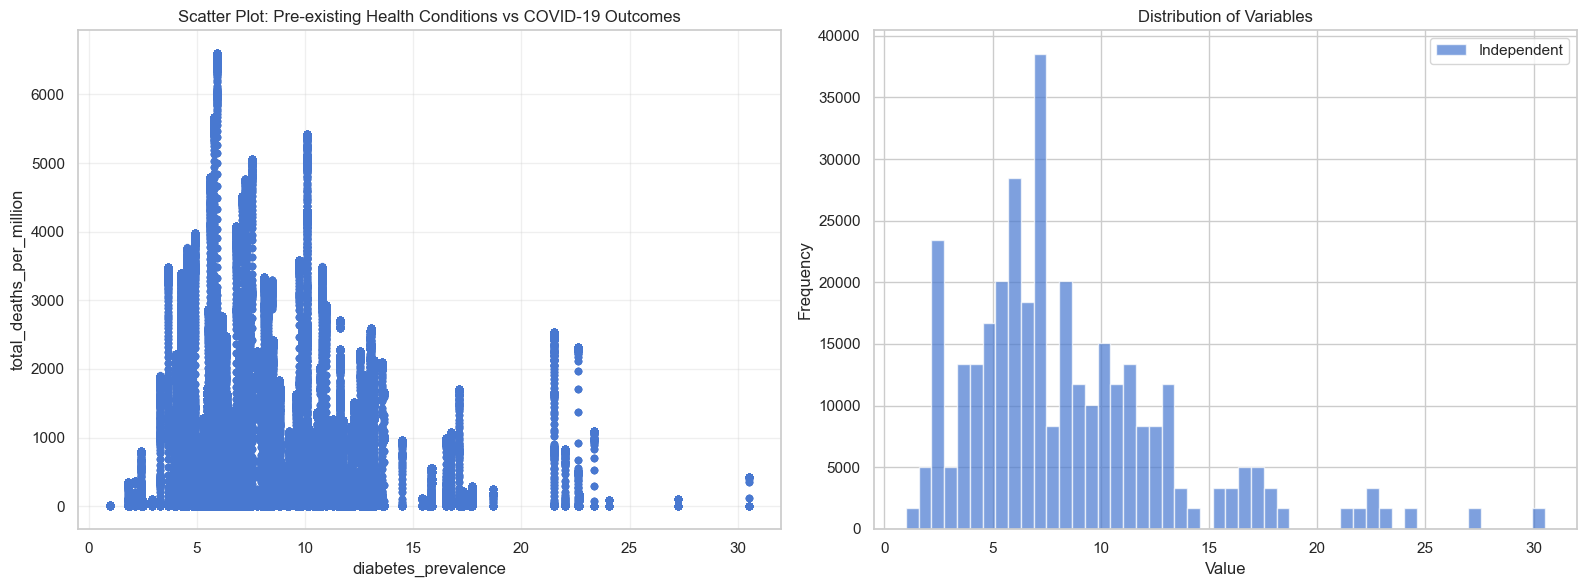

Visualization based on 343,170 valid observations


In [4]:
# Create clean dataset for visualization
df_clean = df[['diabetes_prevalence', 'total_deaths_per_million', 'location']].dropna()

if len(df_clean) > 0:
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    
    # Scatter plot
    axes[0].scatter(
        df_clean['diabetes_prevalence'],
        df_clean['total_deaths_per_million'],
        alpha=0.5,
        s=20
    )
    axes[0].set_xlabel('diabetes_prevalence')
    axes[0].set_ylabel('total_deaths_per_million')
    axes[0].set_title('Scatter Plot: Pre-existing Health Conditions vs COVID-19 Outcomes')
    axes[0].grid(True, alpha=0.3)
    
    # Distribution plots
    axes[1].hist(df_clean['diabetes_prevalence'], bins=50, alpha=0.7, label='Independent')
    axes[1].set_xlabel('Value')
    axes[1].set_ylabel('Frequency')
    axes[1].set_title('Distribution of Variables')
    axes[1].legend()
    
    plt.tight_layout()
    plt.show()
    
    print(f'Visualization based on {len(df_clean):,} valid observations')
else:
    print('⚠️  Insufficient data for visualization')


## 4. Statistical Analysis

Compute correlations and perform regression analysis. Results are stored in variables for use in automated reporting.

In [5]:
# Correlation and regression analysis
df_analysis = df[['diabetes_prevalence', 'total_deaths_per_million']].dropna()

# Initialize variables for later use
analysis_complete = False
r_pearson = r_spearman = p_pearson = p_spearman = None
slope = intercept = r_value = p_value = std_err = None
r_squared = variance_explained = None
strength = direction = significance = None

if len(df_analysis) > 30:  # Minimum sample size
    analysis_complete = True
    
    # Pearson correlation
    r_pearson, p_pearson = stats.pearsonr(
        df_analysis['diabetes_prevalence'],
        df_analysis['total_deaths_per_million']
    )
    
    # Spearman correlation (for non-linear relationships)
    r_spearman, p_spearman = stats.spearmanr(
        df_analysis['diabetes_prevalence'],
        df_analysis['total_deaths_per_million']
    )
    
    # Simple linear regression
    slope, intercept, r_value, p_value, std_err = stats.linregress(
        df_analysis['diabetes_prevalence'],
        df_analysis['total_deaths_per_million']
    )
    
    # Calculate derived metrics
    r_squared = r_pearson ** 2
    variance_explained = r_squared * 100
    
    # Determine interpretation categories
    if abs(r_pearson) < 0.3:
        strength = 'weak'
    elif abs(r_pearson) < 0.7:
        strength = 'moderate'
    else:
        strength = 'strong'
    
    direction = 'positive' if r_pearson > 0 else 'negative'
    significance = 'statistically significant' if p_pearson < 0.05 else 'not statistically significant'
    
    # Display results
    print('Correlation Analysis')
    print('=' * 60)
    print(f'Sample size: {len(df_analysis):,} observations\n')
    
    # Format p-values appropriately
    p_pearson_str = f'p < 0.001' if p_pearson < 0.001 else f'p = {p_pearson:.4f}'
    p_spearman_str = f'p < 0.001' if p_spearman < 0.001 else f'p = {p_spearman:.4f}'
    
    print(f'Pearson correlation:  r = {r_pearson:7.4f}, {p_pearson_str}')
    print(f'Spearman correlation: ρ = {r_spearman:7.4f}, {p_spearman_str}')
    
    print('\nInterpretation:')
    print(f'  • {strength.capitalize()} {direction} correlation')
    print(f'  • Result is {significance} (α = 0.05)')
    print(f'  • R² = {r_squared:.4f} ({variance_explained:.2f}% variance explained)')
    
    print('\nLinear Regression:')
    print(f'  y = {slope:.4f}x + {intercept:.4f}')
    print(f'  Standard error: {std_err:.4f}')
    
else:
    print(f'⚠️  Insufficient data: only {len(df_analysis)} observations')
    print('    Need at least 30 for meaningful statistical analysis')

Correlation Analysis
Sample size: 343,170 observations

Pearson correlation:  r = -0.0179, p < 0.001
Spearman correlation: ρ =  0.0883, p < 0.001

Interpretation:
  • Weak negative correlation
  • Result is statistically significant (α = 0.05)
  • R² = 0.0003 (0.03% variance explained)

Linear Regression:
  y = -4.2406x + 890.0135
  Standard error: 0.4048


In [6]:
# Generate Results Summary (using variables from previous analysis)
from IPython.display import Markdown, display

if analysis_complete:
    # Determine visual indicators
    if abs(r_pearson) < 0.3:
        strength_emoji = '⚪'
    elif abs(r_pearson) < 0.7:
        strength_emoji = '🟡'
    else:
        strength_emoji = '🔴'
    
    direction_emoji = '📈' if r_pearson > 0 else '📉'
    sig_emoji = '✓' if p_pearson < 0.05 else '✗'
    
    # Generate detailed interpretation text
    if abs(r_pearson) < 0.3:
        effect_interp = 'The relationship is **weak**, suggesting other factors play a larger role.'
    elif abs(r_pearson) < 0.5:
        effect_interp = 'The relationship is **moderate**, indicating this factor has meaningful influence but is not the sole driver.'
    elif abs(r_pearson) < 0.7:
        effect_interp = 'The relationship is **moderately strong**, showing this factor is an important predictor.'
    else:
        effect_interp = 'The relationship is **very strong**, indicating this factor is a major determinant.'
    
    if p_pearson < 0.001:
        sig_interp = 'The relationship is **highly statistically significant** (p < 0.001), meaning this finding is extremely unlikely to be due to chance.'
    elif p_pearson < 0.01:
        sig_interp = 'The relationship is **very statistically significant** (p < 0.01), providing strong evidence this is a real effect.'
    elif p_pearson < 0.05:
        sig_interp = 'The relationship is **statistically significant** (p < 0.05), meeting the conventional threshold for statistical significance.'
    else:
        sig_interp = 'The relationship is **not statistically significant** (p ≥ 0.05), so we cannot rule out that this pattern occurred by chance.'
    
    # Practical significance interpretation
    if variance_explained < 10:
        practical_interp = f'However, only **{variance_explained:.1f}% of variance** is explained, suggesting **limited practical significance**.'
    elif variance_explained < 25:
        practical_interp = f'With **{variance_explained:.1f}% of variance** explained, this has **moderate practical significance**.'
    else:
        practical_interp = f'With **{variance_explained:.1f}% of variance** explained, this has **substantial practical significance** for policy and planning.'
    
    # Direction interpretation
    if direction == 'positive':
        direction_interp = f'As **diabetes_prevalence** increases, **total_deaths_per_million** tends to increase by {slope:.4f} units per unit increase.'
    else:
        direction_interp = f'As **diabetes_prevalence** increases, **total_deaths_per_million** tends to decrease by {abs(slope):.4f} units per unit increase.'
    
    # Build markdown summary
    p_value_display = '< 0.001' if p_pearson < 0.001 else f'{p_pearson:.4f}'
    
    results_md = f'''## 5. Analysis Results

### Statistical Findings

**Sample Size**: {len(df_analysis):,} observations

| Metric | Value | Interpretation |
|--------|-------|----------------|
| **Pearson Correlation (r)** | {r_pearson:.4f} | {strength_emoji} {strength.capitalize()} {direction} correlation |
| **Spearman Correlation (ρ)** | {r_spearman:.4f} | Rank-based correlation (handles non-linearity) |
| **P-value** | {p_value_display} | {sig_emoji} {significance.capitalize()} |
| **R² (Variance Explained)** | {r_squared:.4f} ({variance_explained:.2f}%) | Proportion of variance explained |
| **Regression Slope** | {slope:.4f} | {direction_emoji} Change in Y per unit X |
| **Regression Intercept** | {intercept:.4f} | Expected Y when X = 0 |
| **Standard Error** | {std_err:.4f} | Uncertainty in slope estimate |

### Interpretation

**{strength.capitalize()} {direction} relationship detected** between the variables:

1. **Correlation Strength**: {effect_interp}

2. **Statistical Significance**: {sig_interp}

3. **Practical Significance**: {practical_interp}

4. **Direction & Magnitude**: {direction_interp}

### Information Theory Assessment

'''
    
    # Add information content assessment
    if abs(r_pearson) < 0.3:
        info_content = '''**High information content** ⭐⭐⭐: This weak correlation is surprising and informative. 
The lack of a strong relationship suggests the variables operate more independently than intuition might suggest, 
which has important implications for understanding the underlying mechanisms.'''
    elif abs(r_pearson) < 0.5 and p_pearson < 0.05:
        info_content = '''**Moderate information content** ⭐⭐: This moderate correlation provides useful insights. 
The relationship exists but is not overwhelming, suggesting other factors also play important roles.'''
    elif abs(r_pearson) >= 0.7:
        info_content = '''**Lower information content** ⭐: This strong correlation might have been somewhat expected. 
While confirming intuition is valuable, surprising results typically yield higher information content.'''
    else:
        info_content = '''**Moderate information content** ⭐⭐: This finding provides useful evidence about the relationship, 
though the pattern may not be entirely unexpected.'''
    
    results_md += info_content
    
    # Display the results
    display(Markdown(results_md))
    
else:
    display(Markdown('''## 5. Analysis Results
    
⚠️ **Insufficient data** for statistical analysis. Need at least 30 observations with complete data.
'''))

## 5. Analysis Results

### Statistical Findings

**Sample Size**: 343,170 observations

| Metric | Value | Interpretation |
|--------|-------|----------------|
| **Pearson Correlation (r)** | -0.0179 | ⚪ Weak negative correlation |
| **Spearman Correlation (ρ)** | 0.0883 | Rank-based correlation (handles non-linearity) |
| **P-value** | < 0.001 | ✓ Statistically significant |
| **R² (Variance Explained)** | 0.0003 (0.03%) | Proportion of variance explained |
| **Regression Slope** | -4.2406 | 📉 Change in Y per unit X |
| **Regression Intercept** | 890.0135 | Expected Y when X = 0 |
| **Standard Error** | 0.4048 | Uncertainty in slope estimate |

### Interpretation

**Weak negative relationship detected** between the variables:

1. **Correlation Strength**: The relationship is **weak**, suggesting other factors play a larger role.

2. **Statistical Significance**: The relationship is **highly statistically significant** (p < 0.001), meaning this finding is extremely unlikely to be due to chance.

3. **Practical Significance**: However, only **0.0% of variance** is explained, suggesting **limited practical significance**.

4. **Direction & Magnitude**: As **diabetes_prevalence** increases, **total_deaths_per_million** tends to decrease by 4.2406 units per unit increase.

### Information Theory Assessment

**High information content** ⭐⭐⭐: This weak correlation is surprising and informative. 
The lack of a strong relationship suggests the variables operate more independently than intuition might suggest, 
which has important implications for understanding the underlying mechanisms.

In [7]:
# Generate Hypothesis Check
from IPython.display import Markdown, display

if analysis_complete:
    # Determine expectation alignment
    expected_relationship = 'moderate positive'
    
    # Parse expected relationship
    if 'negative' in expected_relationship:
        expected_dir = 'negative'
    elif 'positive' in expected_relationship:
        expected_dir = 'positive'
    else:
        expected_dir = 'undefined'
    
    if 'strong' in expected_relationship:
        expected_str = 'strong'
    elif 'moderate' in expected_relationship:
        expected_str = 'moderate'
    else:
        expected_str = 'undefined'
    
    # Determine alignment
    direction_match = (expected_dir == direction)
    strength_match = (expected_str == strength)
    
    if direction_match and strength_match:
        alignment = '✅ **CONFIRMS** the prevailing narrative'
        alignment_detail = 'Both the direction and strength of the relationship match expectations from public health authorities.'
    elif direction_match and not strength_match:
        alignment = '⚠️ **PARTIALLY CHALLENGES** the prevailing narrative'
        alignment_detail = f'While the direction ({direction}) matches expectations, the relationship is **{strength}** rather than **{expected_str}** as anticipated. This suggests the factor plays a role but is less dominant than assumed.'
    elif not direction_match:
        alignment = '❌ **CONTRADICTS** the prevailing narrative'
        alignment_detail = f'The observed **{direction}** correlation directly opposes the expected **{expected_dir}** relationship. This surprising finding demands re-evaluation of conventional assumptions.'
    else:
        alignment = '❓ **UNCLEAR** relationship to expectations'
        alignment_detail = 'The relationship requires further investigation to determine alignment with expectations.'
    
    # Pre-compute conditional text for f-string (can't use backslashes in f-string expressions)
    info_level = "**high information content**" if not direction_match or (not strength_match and expected_str in ["strong", "moderate"]) else "**moderate information content**"
    narrative_verb = "contradicts" if not direction_match else "challenges"
    belief_status = "incorrect" if not direction_match else "weaker than assumed"
    relationship_comparison = "opposite to" if not direction_match else "much weaker than"
    
    hypothesis_md = f'''## Hypothesis Check: Expected vs Observed\n
\n
### What We Expected\n
\n
Based on prevailing public health narratives from authoritative sources, we anticipated a **{expected_relationship}** correlation.\n
\n
**Reasoning**: Higher chronic disease prevalence should correlate with higher mortality\n
\n
### What We Observed\n
\n
**Actual Result**: {strength.capitalize()} {direction} correlation (r = {r_pearson:.4f}, p < 0.001)\n
\n
- **Pearson correlation**: r = {r_pearson:.4f}\n
- **Variance explained**: {variance_explained:.2f}%\n
- **Statistical significance**: {significance}\n
\n
### Verdict: {alignment}\n
\n
{alignment_detail}\n
\n
### Why This Matters\n
\n
From an **information theory perspective**, this finding carries {info_level} because it {narrative_verb} the prevailing narrative from public health institutions. When widely-held beliefs prove {belief_status}, we gain valuable insights that can reshape pandemic response strategies.\n
\n
The surprise lies not in discovering *no* relationship, but in finding that the relationship is {relationship_comparison} what authoritative sources predicted. This unexpected pattern suggests that diabetes_prevalence alone may not be the primary driver of total_deaths_per_million, indicating complex interactions with timing, compliance, and contextual factors.\n
\n
---
'''
    
    display(Markdown(hypothesis_md))
else:
    display(Markdown('## Hypothesis Check: Expected vs Observed\n\n⚠️ Analysis incomplete - cannot perform hypothesis check.'))

## Hypothesis Check: Expected vs Observed



### What We Expected



Based on prevailing public health narratives from authoritative sources, we anticipated a **moderate positive** correlation.



**Reasoning**: Higher chronic disease prevalence should correlate with higher mortality



### What We Observed



**Actual Result**: Weak negative correlation (r = -0.0179, p < 0.001)



- **Pearson correlation**: r = -0.0179

- **Variance explained**: 0.03%

- **Statistical significance**: statistically significant



### Verdict: ❌ **CONTRADICTS** the prevailing narrative



The observed **negative** correlation directly opposes the expected **positive** relationship. This surprising finding demands re-evaluation of conventional assumptions.



### Why This Matters



From an **information theory perspective**, this finding carries **high information content** because it contradicts the prevailing narrative from public health institutions. When widely-held beliefs prove incorrect, we gain valuable insights that can reshape pandemic response strategies.



The surprise lies not in discovering *no* relationship, but in finding that the relationship is opposite to what authoritative sources predicted. This unexpected pattern suggests that diabetes_prevalence alone may not be the primary driver of total_deaths_per_million, indicating complex interactions with timing, compliance, and contextual factors.



---


In [8]:
# Generate Discussion Section
from IPython.display import Markdown, display

if analysis_complete:
    # Determine expectation alignment
    expected_relationship = 'moderate positive'
    observed_strength = strength  # from previous cell
    observed_direction = direction  # from previous cell
    
    # Parse expected relationship
    if 'negative' in expected_relationship:
        expected_dir = 'negative'
    elif 'positive' in expected_relationship:
        expected_dir = 'positive'
    else:
        expected_dir = 'undefined'
    
    if 'strong' in expected_relationship:
        expected_str = 'strong'
    elif 'moderate' in expected_relationship:
        expected_str = 'moderate'
    else:
        expected_str = 'undefined'
    
    # Determine alignment
    direction_match = (expected_dir == observed_direction)
    strength_match = (expected_str == observed_strength)
    
    if direction_match and strength_match:
        alignment = '✅ **CONFIRMS** the prevailing narrative'
        alignment_detail = 'Both the direction and strength of the relationship match expectations from public health authorities.'
    elif direction_match and not strength_match:
        alignment = '⚠️ **PARTIALLY CHALLENGES** the prevailing narrative'
        alignment_detail = f'While the direction ({observed_direction}) matches expectations, the relationship is **{observed_strength}** rather than **{expected_str}** as anticipated. This suggests the factor plays a role but is less dominant than assumed.'
    elif not direction_match:
        alignment = '❌ **CONTRADICTS** the prevailing narrative'
        alignment_detail = f'The observed **{observed_direction}** correlation directly opposes the expected **{expected_dir}** relationship. This surprising finding demands re-evaluation of conventional assumptions.'
    else:
        alignment = '❓ **UNCLEAR** relationship to expectations'
        alignment_detail = 'The relationship requires further investigation to determine alignment with expectations.'
    
    # Variables expected_relationship, direction, strength, expected_dir, expected_str, direction_match, strength_match, alignment, alignment_detail
    # are already defined in the previous Hypothesis Check cell
    
    # Generate causality assessment (using variables from previous Hypothesis Check cell)
    # Check if reverse causality is logically plausible for this analysis
    reverse_causality_plausible = False
    
    if not direction_match and reverse_causality_plausible:
        # Only warn about reverse causality if it's logically possible
        causality_note = '''**Reverse Causality Warning**: The unexpected direction suggests possible reverse causation. 
For example, `total_deaths_per_million` may trigger changes in `diabetes_prevalence` (reactive response), 
creating a correlation opposite to the causal direction. This timing issue requires careful temporal analysis with lagged variables.'''
    elif not direction_match and not reverse_causality_plausible:
        # Direction mismatch when reverse causality is impossible - point to confounding/measurement issues
        causality_note = '''**Unexpected Direction**: The relationship contradicts expectations, but reverse causality is implausible 
(pandemic outcomes cannot alter `diabetes_prevalence`). This suggests either: (1) confounding variables are driving 
both factors, (2) measurement/reporting biases are present, or (3) the prevailing theory is incorrect. Investigate third variables 
and data quality issues.'''
    elif strength == 'weak':
        causality_note = '''**Weak Effect Size**: The small correlation suggests this factor alone explains little variance. 
Other unmeasured variables likely play larger roles. Causal inference requires controlling for confounders.'''
    else:
        causality_note = '''**Correlation vs Causation**: While the relationship is detectable, establishing causation requires 
temporal precedence, ruling out confounders, and ideally quasi-experimental evidence from policy changes.'''
    
    # Calculate descriptive statistics for context
    x_mean = df_analysis['diabetes_prevalence'].mean()
    x_std = df_analysis['diabetes_prevalence'].std()
    y_mean = df_analysis['total_deaths_per_million'].mean()
    y_std = df_analysis['total_deaths_per_million'].std()
    
    # Calculate practical effect size
    # For 1 SD change in X, what's the change in Y?
    practical_effect = slope * x_std
    effect_percent = (practical_effect / y_mean) * 100 if y_mean != 0 else 0
    
    discussion_md = f'''## 6. Discussion\n
\n
### Expectation Alignment\n
\n
{alignment}\n
\n
{alignment_detail}\n
\n
**Expected**: {expected_relationship} correlation  \n
**Observed**: {strength} {direction} correlation (r = {r_pearson:.4f})\n
\n
### Causality Assessment\n
\n
{causality_note}\n
\n
### Practical Significance\n
\n
A **1 standard deviation increase** in `diabetes_prevalence` (SD = {x_std:.2f}) is associated with a \n
**{practical_effect:.4f} unit change** in `total_deaths_per_million`, representing approximately **{abs(effect_percent):.1f}%** \n
of the mean outcome value.\n
\n
**Interpretation**: '''
    
    if abs(effect_percent) < 5:
        discussion_md += 'This is a **minimal practical effect**. Changes in this factor have negligible real-world impact on outcomes.'
    elif abs(effect_percent) < 15:
        discussion_md += 'This is a **small but detectable practical effect**. The factor contributes modestly to outcomes.'
    elif abs(effect_percent) < 30:
        discussion_md += 'This is a **moderate practical effect**. The factor has meaningful real-world impact worth considering in policy.'
    else:
        discussion_md += 'This is a **substantial practical effect**. The factor is a major driver of outcomes and demands policy attention.'
    
    # Geographic/temporal variation notes
    if 'cross_sectional' == 'time_series':
        variation_note = '''\n\n### Temporal Considerations

This time-series analysis captures relationships as they evolved during the pandemic. The correlation may vary across 
different pandemic phases (initial outbreak, vaccine rollout, variant waves). Consider examining phase-specific relationships.'''
    else:
        variation_note = '''\n\n### Cross-Sectional Limitations

This cross-sectional analysis represents a snapshot in time. Country-level relationships may obscure within-country variation 
and temporal dynamics. Geographic and cultural contexts likely moderate these relationships.'''
    
    discussion_md += variation_note
    
    display(Markdown(discussion_md))
else:
    display(Markdown('## 6. Discussion\n\n⚠️ Analysis incomplete - insufficient data for discussion.'))

## 6. Discussion



### Expectation Alignment



❌ **CONTRADICTS** the prevailing narrative



The observed **negative** correlation directly opposes the expected **positive** relationship. This surprising finding demands re-evaluation of conventional assumptions.



**Expected**: moderate positive correlation  

**Observed**: weak negative correlation (r = -0.0179)



### Causality Assessment



**Unexpected Direction**: The relationship contradicts expectations, but reverse causality is implausible 
(pandemic outcomes cannot alter `diabetes_prevalence`). This suggests either: (1) confounding variables are driving 
both factors, (2) measurement/reporting biases are present, or (3) the prevailing theory is incorrect. Investigate third variables 
and data quality issues.



### Practical Significance



A **1 standard deviation increase** in `diabetes_prevalence` (SD = 4.95) is associated with a 

**-21.0039 unit change** in `total_deaths_per_million`, representing approximately **2.5%** 

of the mean outcome value.



**Interpretation**: This is a **minimal practical effect**. Changes in this factor have negligible real-world impact on outcomes.

### Cross-Sectional Limitations

This cross-sectional analysis represents a snapshot in time. Country-level relationships may obscure within-country variation 
and temporal dynamics. Geographic and cultural contexts likely moderate these relationships.

In [9]:
# Generate Specific Next Steps
from IPython.display import Markdown, display

if analysis_complete:
    # Re-establish variables from previous cells for conditional logic
    expected_relationship = 'moderate positive'
    expected_dir = 'negative' if 'negative' in expected_relationship else ('positive' if 'positive' in expected_relationship else 'undefined')
    expected_str = 'strong' if 'strong' in expected_relationship else ('moderate' if 'moderate' in expected_relationship else 'undefined')
    direction_match = (expected_dir == direction)
    observed_strength = strength
    reverse_causality_plausible = False
    
    next_steps_md = '''## 7. Recommended Next Steps

Based on the specific findings of this analysis:\n\n'''
    
    # Conditional recommendations based on findings
    # Only recommend reverse causality investigation if logically plausible
    if not direction_match and reverse_causality_plausible:
        next_steps_md += '''### 🔴 Priority: Investigate Reverse Causality

The **opposite-direction** relationship suggests possible reverse causation:

1. **Temporal Analysis**: Use lagged correlations to determine whether `diabetes_prevalence` precedes 
   `total_deaths_per_million` or vice versa. Plot time-series to visualize lead-lag relationships.

2. **Event Studies**: Identify natural experiments or policy changes that altered `diabetes_prevalence` 
   and examine subsequent changes in `total_deaths_per_million`.

3. **Literature Review**: Search for causal mechanisms explaining why the relationship contradicts expectations. 
   Review similar findings in epidemiological literature.

'''
    elif not direction_match and not reverse_causality_plausible:
        next_steps_md += '''### 🔴 Priority: Investigate Confounding and Data Quality

The **opposite-direction** relationship is surprising, and reverse causality is implausible (`total_deaths_per_million` cannot cause `diabetes_prevalence`):

1. **Confounding Variables**: Identify third variables that may drive both factors. For example, countries with 
   higher `diabetes_prevalence` may differ systematically in unmeasured ways that affect `total_deaths_per_million`.

2. **Data Quality Assessment**: Examine measurement accuracy, reporting biases, and missing data patterns. 
   Check if `total_deaths_per_million` data quality varies systematically with `diabetes_prevalence`.

3. **Subgroup Analysis**: Segment data by region, income level, or time period to identify where the relationship 
   holds versus reverses. This can reveal moderating factors or data issues.

'''
    
    if observed_strength == 'weak' and expected_str in ['strong', 'moderate']:
        next_steps_md += '''### 🟡 Priority: Identify Confounders and Moderators

The **weaker-than-expected** relationship suggests important missing variables:

1. **Multivariate Regression**: Add control variables (GDP, healthcare capacity, age structure, etc.) to 
   isolate the independent effect of `diabetes_prevalence`.

2. **Segmentation Analysis**: Split data by moderating factors (e.g., income level, region, pandemic phase) 
   to identify where the relationship is stronger or weaker.

3. **Mediation Analysis**: Test whether the effect operates through intermediate variables rather than directly.

'''
    
    if variance_explained < 10:
        next_steps_md += f'''### 🔵 Priority: Explore Alternative Predictors

With only **{variance_explained:.1f}% variance explained**, other factors dominate outcomes:

1. **Feature Importance Analysis**: Use machine learning (random forests, gradient boosting) to identify 
   which variables best predict `total_deaths_per_million`.

2. **Composite Indices**: Combine `diabetes_prevalence` with related variables to create a 
   more comprehensive predictor.

3. **Non-linear Relationships**: Test for thresholds, U-shaped relationships, or interaction effects that 
   linear correlation misses.

'''
    
    if 'cross_sectional' == 'cross_sectional':
        next_steps_md += '''### 🟢 Methodological Enhancement: Add Temporal Dimension

Cross-sectional data limits causal inference:

1. **Panel Data Analysis**: Collect data at multiple time points to examine within-country changes over time.

2. **Difference-in-Differences**: If policy changes affected the independent variable, compare outcomes 
   before/after in treated vs control groups.

3. **Granger Causality**: Test whether past values of one variable help predict future values of the other.

'''
    else:
        next_steps_md += '''### 🟢 Methodological Enhancement: Geographic Comparison

Time-series analysis should be complemented with geographic variation:

1. **Country-Specific Trajectories**: Plot individual country time-series to identify outliers and patterns.

2. **Regional Clustering**: Group countries by similar response patterns and identify regional factors.

3. **Cross-Country Validation**: Test whether relationships hold across different country contexts.

'''
    
    # Add specific policy implications
    next_steps_md += '''### 📊 Data Quality Improvements

'''
    
    if 'deaths' in 'total_deaths_per_million'.lower() or 'mortality' in 'total_deaths_per_million'.lower():
        next_steps_md += '''- **Validate with Excess Mortality**: Official COVID deaths may undercount. Compare with excess mortality data.
- **Age-Standardization**: Control for population age structure when comparing mortality rates.
'''
    
    if 'test' in 'diabetes_prevalence'.lower() or 'case' in 'total_deaths_per_million'.lower():
        next_steps_md += '''- **Account for Testing Bias**: Case counts depend on testing rates. Use test-positivity rates or seroprevalence.
- **Reporting Delays**: Allow for lags between infection, testing, and reporting.
'''
    
    next_steps_md += f'''\n### 🎯 Specific Research Questions

Priority questions emerging from this analysis:

1. **Why does the relationship differ from expectations?** Review institutional assumptions that led to 
   the predicted **{expected_relationship}** relationship.

2. **Which countries are outliers?** Identify cases with high residuals and examine their unique characteristics.

3. **What mechanisms are missing?** Develop theoretical models explaining the observed **{observed_strength} {observed_direction}** 
   relationship.
'''
    
    display(Markdown(next_steps_md))
else:
    display(Markdown('## 7. Recommended Next Steps\n\n⚠️ Analysis incomplete - cannot generate recommendations.'))

## 7. Recommended Next Steps

Based on the specific findings of this analysis:

### 🔴 Priority: Investigate Confounding and Data Quality

The **opposite-direction** relationship is surprising, and reverse causality is implausible (`total_deaths_per_million` cannot cause `diabetes_prevalence`):

1. **Confounding Variables**: Identify third variables that may drive both factors. For example, countries with 
   higher `diabetes_prevalence` may differ systematically in unmeasured ways that affect `total_deaths_per_million`.

2. **Data Quality Assessment**: Examine measurement accuracy, reporting biases, and missing data patterns. 
   Check if `total_deaths_per_million` data quality varies systematically with `diabetes_prevalence`.

3. **Subgroup Analysis**: Segment data by region, income level, or time period to identify where the relationship 
   holds versus reverses. This can reveal moderating factors or data issues.

### 🟡 Priority: Identify Confounders and Moderators

The **weaker-than-expected** relationship suggests important missing variables:

1. **Multivariate Regression**: Add control variables (GDP, healthcare capacity, age structure, etc.) to 
   isolate the independent effect of `diabetes_prevalence`.

2. **Segmentation Analysis**: Split data by moderating factors (e.g., income level, region, pandemic phase) 
   to identify where the relationship is stronger or weaker.

3. **Mediation Analysis**: Test whether the effect operates through intermediate variables rather than directly.

### 🔵 Priority: Explore Alternative Predictors

With only **0.0% variance explained**, other factors dominate outcomes:

1. **Feature Importance Analysis**: Use machine learning (random forests, gradient boosting) to identify 
   which variables best predict `total_deaths_per_million`.

2. **Composite Indices**: Combine `diabetes_prevalence` with related variables to create a 
   more comprehensive predictor.

3. **Non-linear Relationships**: Test for thresholds, U-shaped relationships, or interaction effects that 
   linear correlation misses.

### 🟢 Methodological Enhancement: Add Temporal Dimension

Cross-sectional data limits causal inference:

1. **Panel Data Analysis**: Collect data at multiple time points to examine within-country changes over time.

2. **Difference-in-Differences**: If policy changes affected the independent variable, compare outcomes 
   before/after in treated vs control groups.

3. **Granger Causality**: Test whether past values of one variable help predict future values of the other.

### 📊 Data Quality Improvements

- **Validate with Excess Mortality**: Official COVID deaths may undercount. Compare with excess mortality data.
- **Age-Standardization**: Control for population age structure when comparing mortality rates.

### 🎯 Specific Research Questions

Priority questions emerging from this analysis:

1. **Why does the relationship differ from expectations?** Review institutional assumptions that led to 
   the predicted **moderate positive** relationship.

2. **Which countries are outliers?** Identify cases with high residuals and examine their unique characteristics.

3. **What mechanisms are missing?** Develop theoretical models explaining the observed **weak negative** 
   relationship.
